# Logistic Regression for fraud detection

The objective of this project is to detect if financial transactions are fraudulent, using Logistic Regression. The dataset used in this project is synthetic but based on real data. 

**Source code**: the data comes from [Kaggle](https://www.kaggle.com/datasets/ealaxi/paysim1?datasetId=1069&sortBy=voteCount).

The project is divided in the following sections:
- **Import modules and read the data**
- **Prepare data** 
- **Build model**
- **Optimization**

## Import modules and read the data

In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv', nrows=10000)

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


The dataset has the following columns:

- `step`: maps a unit of time in the real world. In this case 1 step is 1 hour of time. 
- `type`: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
- `amount`: amount of the transaction in local currency.
- `nameOrig`: customer who started the transaction
- `oldbalanceOrg`: initial balance before the transaction
- `newbalanceOrig`: new balance after the transaction.
- `nameDest`: customer who is the recipient of the transaction
- `oldbalanceDest`: initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
- `newbalanceDest`: new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
- `isFraud`: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
- `isFlaggedFraud`: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

Transactions which are detected as fraud are cancelled, so for fraud detection these columns (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ) must not be used.

## Prepare data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            10000 non-null  int64  
 1   type            10000 non-null  object 
 2   amount          10000 non-null  float64
 3   nameOrig        10000 non-null  object 
 4   oldbalanceOrg   10000 non-null  float64
 5   newbalanceOrig  10000 non-null  float64
 6   nameDest        10000 non-null  object 
 7   oldbalanceDest  10000 non-null  float64
 8   newbalanceDest  10000 non-null  float64
 9   isFraud         10000 non-null  int64  
 10  isFlaggedFraud  10000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 859.5+ KB


In [6]:
df.describe(include='all')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,10000.000000,10000,1.000000e+04,10000,1.000000e+04,1.000000e+04,10000,1.000000e+04,1.000000e+04,10000.000000,10000.0
unique,NaN,5,NaN,10000,NaN,NaN,6397,NaN,NaN,NaN,NaN
top,NaN,PAYMENT,NaN,C1231006815,NaN,NaN,C985934102,NaN,NaN,NaN,NaN
freq,NaN,5465,NaN,1,NaN,NaN,62,NaN,NaN,NaN,NaN
mean,4.178900,NaN,1.035467e+05,NaN,8.939330e+05,9.152741e+05,NaN,9.342758e+05,1.096606e+06,0.006800,0.0
std,2.479821,NaN,2.663072e+05,NaN,2.135683e+06,2.181428e+06,NaN,2.676340e+06,3.014496e+06,0.082185,0.0
min,1.000000,NaN,2.390000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000,0.0
25%,1.000000,NaN,4.397530e+03,NaN,1.276875e+02,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000,0.0
50%,5.000000,NaN,1.285874e+04,NaN,2.137556e+04,1.034994e+04,NaN,0.000000e+00,0.000000e+00,0.000000,0.0
75%,7.000000,NaN,1.143825e+05,NaN,1.782719e+05,1.760934e+05,NaN,2.831067e+05,2.520552e+05,0.000000,0.0


In [7]:
df.isFraud.value_counts()

0    9932
1      68
Name: isFraud, dtype: int64

In [8]:
df['isPayment'] = [1 if (x == 'PAYMENT'or x == 'DEBIT') else 0 for x in df['type']]
df['isMovement'] = [1 if (x == 'CASH_OUT'or x == 'TRANSFER') else 0 for x in df['type']]
df['accountDiff'] = df['oldbalanceOrg'] - df['oldbalanceDest']

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isPayment,isMovement,accountDiff
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,0,170136.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,0,21249.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,1,181.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,-21001.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,0,41554.0


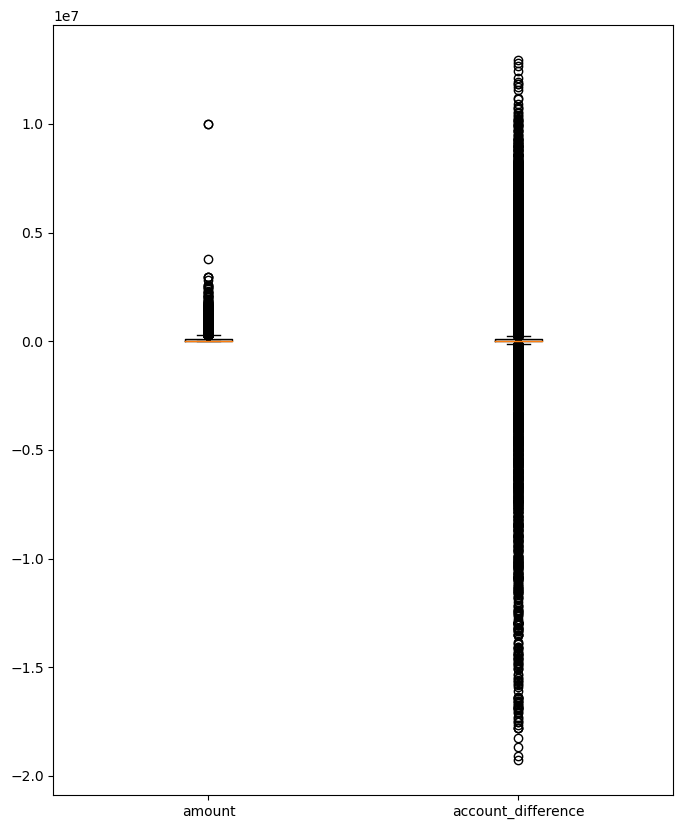

In [33]:
# Check for outliers
plt.figure(figsize=(8, 10))
plt.boxplot([df['amount'], df['accountDiff']], labels=['amount', 'account_difference'])
plt.show()

In [23]:
X = df[['amount', 'isPayment', 'isMovement', 'accountDiff']]
y = df['isFraud']

X = X[X['amount'] < 5000000]

## Build the model

In [49]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Divide data in training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

# Build model and fit data
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Predict new y value based on x test values
y_predict = lr.predict(X_test)

# Create confusion matrix to evaluate results
test_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_predict), 
    index=['actual no', 'actual yes'], 
    columns=['predicted no', 'predicted yes']
)

test_conf_matrix

,predicted no,predicted yes
actual no,2985,0
actual yes,15,0


We have 15 frauds that haven't been identified by the model.

## Optimization

In [39]:
# Try to make better model - balance weight
lr_bal = LogisticRegression(penalty=None, max_iter=1000, fit_intercept=True, tol=0.000001, class_weight = 'balanced')
lr_bal.fit(X_train, y_train)

y_predict = lr_bal.predict(X_test)

test_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_predict), 
    index=['actual no', 'actual yes'], 
    columns=['predicted no', 'predicted yes']
)

test_conf_matrix

,predicted no,predicted yes
actual no,2689,296
actual yes,1,14


Using balanced weights leads to a model that can identify almost all frudulent transactions, however the false positives also increase. \
Have a look at coefficients to see if you can get rid of some of them.

In [46]:
coef_df = pd.DataFrame(
  zip(X.columns, lr_bal.coef_[0]), 
  columns=['var', 'coef'])\
  .sort_values('coef', ascending=False)
coef_df

,var,coef
2,isMovement,44.218890
3,accountDiff,22.389476
1,isPayment,15.297244
0,amount,0.394073


Looks like the feature `amount` has a very low coefficient, meaning that its contribution to the prediction is low. Try to get rid of it and see if the model performs better.

In [48]:
# Remove features
X = df[['isPayment', 'isMovement', 'accountDiff']]
y = df['isFraud']

lr_bal = LogisticRegression(penalty=None, max_iter=1000, fit_intercept=True, tol=0.000001, class_weight = 'balanced')
lr_bal.fit(X_train, y_train)

y_predict = lr_bal.predict(X_test)

test_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_predict), 
    index=['actual no', 'actual yes'], 
    columns=['predicted no', 'predicted yes']
)

test_conf_matrix

,predicted no,predicted yes
actual no,2689,296
actual yes,1,14
